<b> Author: </b> Christina Kouridi  
<b> Date: </b>  17/3/2021

# Data cleaning

<b> Objective </b>: This notebook goes through the data cleaning process for [NYC 311 dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9), and explains key decisions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from uszipcode import SearchEngine

# dataframe display settings
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

# seed for PRNGs
np.random.seed(0)

### Load data

- To work efficiently, we will only load columns that will be utilised in subsequent analysis
- The number of rows `nrows` should be limited such that the dataset fits in memory. The total number of rows (~25M) roughly occupy ~15GB of memory
- We indicate data types upon loading, especially `string`, as columns with mixed data types are stored as objects which are very memory intensive

In [2]:
column_to_dtype = {'Unique Key': 'int', 
                   'Created Date': 'string',
                   'Closed Date': 'string', 
                   'Agency': 'string',
                   'Complaint Type': 'string',
                   'Incident Zip': 'string',
                   'Status': 'string',
                   'Resolution Description': 'string',
                   'Latitude': 'float',
                   'Longitude': 'float'
                   }

df = pd.read_csv('data/311_Service_Requests_from_2010_to_Present.csv', 
                 usecols=column_to_dtype.keys(), 
                 dtype=column_to_dtype)

len_df_raw = len(df)  # store for reference

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25115321 entries, 0 to 25115320
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unique Key              int64  
 1   Created Date            string 
 2   Closed Date             string 
 3   Agency                  string 
 4   Complaint Type          string 
 5   Incident Zip            string 
 6   Status                  string 
 7   Resolution Description  string 
 8   Latitude                float64
 9   Longitude               float64
dtypes: float64(2), int64(1), string(7)
memory usage: 15.2 GB


As expected, long strings occupy the most memory

In [3]:
df.memory_usage(deep=True) / 1024**2

Index                        0.000122
Unique Key                 191.614693
Created Date              1892.195090
Closed Date               1866.664941
Agency                    1450.472558
Complaint Type            1759.805104
Incident Zip              1456.153008
Status                    1509.995279
Resolution Description    5079.912370
Latitude                   191.614693
Longitude                  191.614693
dtype: float64

We change column names to a more convenient format for quick indexing

In [4]:
df.columns = ['unique_key', 
              'created_date', 
              'closed_date',
              'agency', 
              'complaint_type', 
              'incident_zip', 
              'status',
              'resolution_description',
              'latitude', 
              'longitude']

df.head()

,unique_key,created_date,closed_date,agency,complaint_type,incident_zip,status,resolution_description,latitude,longitude
0,16181298,03/10/2010 12:00:00 AM,03/11/2010 12:00:00 AM,HPD,HEATING,11226,Closed,"More than one complaint was received for this building-wide condition.This complaint status is for the initial complaint.The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please",40.654276,-73.961805
1,16180916,03/10/2010 12:00:00 AM,03/18/2010 12:00:00 AM,HPD,NONCONST,11218,Closed,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,40.643209,-73.989035
2,16181945,03/10/2010 12:00:00 AM,03/15/2010 12:00:00 AM,HPD,GENERAL CONSTRUCTION,11225,Closed,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd.,40.663802,-73.952529
3,16181032,03/10/2010 06:24:22 PM,03/15/2010 12:00:00 AM,DOT,Street Condition,10305,Closed,The Department of Transportation inspected this complaint and repaired the problem.,40.600617,-74.064888
4,16182497,03/10/2010 12:00:00 AM,03/18/2010 12:00:00 AM,HPD,PLUMBING,11219,Closed,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd.,40.634132,-73.989476


We'll pay particular attention to nulls in `closed_date` and `incident_zip`; `latitude`, `longitude` and `resolution_description` are only used for demonstration

In [5]:
round(df.isnull().sum(axis=0) * 100 / len(df), 2)

unique_key                0.00
created_date              0.00
closed_date               2.73
agency                    0.00
complaint_type            0.00
incident_zip              5.48
status                    0.00
resolution_description    2.00
latitude                  8.43
longitude                 8.43
dtype: float64

#### Check that the unique key is indeed unique

In [6]:
assert df.unique_key.nunique() == len(df)

### 1.1 Data cleaning: request status (`status`)

This analysis only considers closed requests, thus entries with an open status are dropped. Such requests are more likely to be currently invalid or incomplete, as they may be updated before being closed

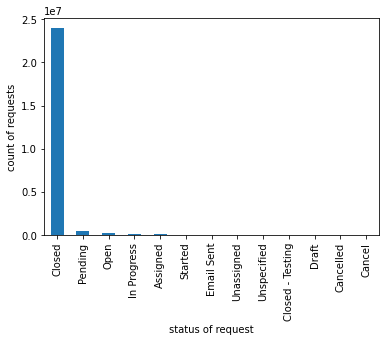

In [7]:
df.status.value_counts().plot(kind='bar')

plt.ylabel('count of requests')
plt.xlabel('status of request')

plt.show()

In [8]:
df = df[df.status == 'Closed'].copy()

### 1.2 Data cleaning: Zip Codes (`incident_zip`)

Steps: 
- strip the first 5 digits in`incident_zip` (assuming that valid ZIP codes in NY state consist of 5 digits [[1](https://www.zip-codes.com/state/ny.asp)])
- drop the null values (already 5.5% of entries according to cell 5)
- drop ZIP codes that do not represent actual areas within NY state. We use the [`uszipcode`](https://pypi.org/project/uszipcode/) USA ZIP code programmable database, which includes up-to-date ZIP code information

Extracting a random set of entries, demonstrates a range of problematic entries, for example:

- 'ANONYMOUS'
- '1735-9100'
- '117'
- '972286995'
- '000000'

In [9]:
np.random.choice(df.incident_zip.unique(), 150)

array(['13039', '55343', '08360-4213', 'ANONYMOUS', '10533', '98130',
       '11560', '11757', '75035', '70002', '10401', '85201', '03110',
       '07733', '42301', '12865', '1735-9100', '60678', '06831',
       '55439-0846', '85053', '133221', '31093', '48195-0954', '77057',
       '63146', '55164-4043', '10475', '37043', '48195-0954', '07608',
       '98036', '11735', '27414', '11020', '18104', '30006', '07112',
       '18966', '11423', '01845', '32119', '117', '23060', '11542',
       '03104', '03104', '35209', 'MN55439', '48090', '06870', '61602',
       '07632', '14203', '60630', '30006', '60649', '32896-5053', '11774',
       '10104', '61702-3068', '10120', '11692', '11690', '78265-9705',
       '31600', '33063', '08690-1717', '10301', '33027', '07081', '14225',
       '11709', '11020', '12508', '07807', '07481', '85251-6547',
       '972286995', '63701', '30348', '11946', '11510', '07653', '10008',
       '11352', '17109-0988', '7117-7032', '32401', '60159-0838',
       '000000'

In [10]:
df['clean_zip'] = df.incident_zip.str.extract(r'([0-9]{5})')

print(f'additional # of null values: {int(df.clean_zip.isna().sum() - df.incident_zip.isna().sum())}')

additional # of null values: 409


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23961199 entries, 0 to 25115320
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   unique_key              int64  
 1   created_date            string 
 2   closed_date             string 
 3   agency                  string 
 4   complaint_type          string 
 5   incident_zip            string 
 6   status                  string 
 7   resolution_description  string 
 8   latitude                float64
 9   longitude               float64
 10  clean_zip               object 
dtypes: float64(2), int64(1), object(1), string(7)
memory usage: 2.1+ GB


In [12]:
# ensure it remains a string for memory efficiency
df['clean_zip'] = df['clean_zip'].astype('string')

In [13]:
# drop rows with null clean_zip
df.dropna(subset=['clean_zip'], inplace=True)

#  test whether all zips have the right length
assert sum(df['clean_zip'].str.len() == 5) == len(df['clean_zip'])

Now that we have ZIP codes of valid length and type, let's do a quick check on whether the ZIP codes represent actual areas within NY

In [14]:
search = SearchEngine()
res = search.by_state(state="New York", returns=0)

valid_zipcodes = [z.zipcode for z in res]
print(f'range of zip-codes: {valid_zipcodes[0]}-{valid_zipcodes[-1]}') 

range of zip-codes: 10001-14925


In [15]:
df.clean_zip.isin(valid_zipcodes).value_counts()

True     22745234
False        9661
Name: clean_zip, dtype: int64

In [16]:
#  this drops zip codes such as 00000
df = df[df.clean_zip.isin(valid_zipcodes)]

`clean_zip` now looks reasonable!

In [17]:
np.random.choice(df.clean_zip.unique(), 150)

array(['11005', '10173', '10605', '11411', '11740', '10104', '10038',
       '10016', '11426', '10467', '10930', '10023', '10595', '11803',
       '14710', '10002', '10105', '14450', '10110', '13905', '10038',
       '10021', '11576', '12024', '11560', '11021', '11001', '10306',
       '10594', '11217', '10601', '10552', '11418', '10031', '11554',
       '10112', '14108', '10035', '10303', '10583', '11103', '11768',
       '14226', '13057', '11241', '10171', '10006', '10036', '14020',
       '10270', '14615', '12590', '10007', '10167', '11703', '13057',
       '10924', '14221', '11733', '11204', '10152', '10460', '11372',
       '11106', '10119', '11221', '14208', '10169', '10573', '11719',
       '11361', '10984', '11427', '10603', '11217', '14526', '11738',
       '10112', '11731', '10170', '11363', '11697', '12401', '10173',
       '14052', '10309', '10469', '10580', '11414', '10523', '11598',
       '10514', '10926', '14209', '11377', '13053', '12779', '10153',
       '11692', '101

### 1.3 Data cleaning: Agency names (`incident_zip`)

None of the smaller agencies have been excluded at this stage, however they are eventually dropped through cleaning other columns

In [18]:
df.agency.value_counts()

NYPD                                       6689295
HPD                                        6285327
DOT                                        2441279
DEP                                        1827327
DSNY                                       1774045
DOB                                        1092770
DPR                                         870684
DOHMH                                       477064
DOF                                         411144
TLC                                         232889
DHS                                         215557
DCA                                         201156
DFTA                                         90371
MAYORâS OFFICE OF SPECIAL ENFORCEMENT      62920
EDC                                          25386
3-1-1                                        20536
DOE                                          19141
DOITT                                         6909
MAYOR'S OFFICE OF SPECIAL ENFORCEMENT         1389
NYCEM                          

There's duplication of 'MAYOR'S OFFICE OF SPECIAL ENFORCEMENT'. Let's standardise it to `OSE`, its rightful acronym [[2](https://www1.nyc.gov/site/specialenforcement/index.page)]

In [19]:
df.agency.replace({'MAYORâS OFFICE OF SPECIAL ENFORCEMENT': 'OSE', 
                   'MAYOR\'S OFFICE OF SPECIAL ENFORCEMENT': 'OSE'}, inplace=True)

In [20]:
# ensure it remains a string for memory efficiency
df['agency'] = df['agency'].astype('string')

### 1.4 Data cleaning: dates (`closed_date` & `created_date`)

Steps:
- we drop invalid `closed_date` entries: when `created_date` > `closed_date` and `closed_date` after today
- we drop rows with null `closed_date` (according to cell 5, ~3% of `closed_date` entries are null) as this analysis only considers completed requests

To enable date comparisons, we convert the data type of these columns from `string` to `datetime`

In [21]:
for col in ['created_date', 'closed_date']:
    # errors = 'coerce' forces out of bound dates to NaT
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %H:%M:%S %p', errors = 'coerce')  

In [22]:
df.isnull().sum(axis=0)

unique_key                     0
created_date                   0
closed_date                 2114
agency                         0
complaint_type                 0
incident_zip                   0
status                         0
resolution_description    417297
latitude                  731875
longitude                 731875
clean_zip                      0
dtype: int64

In [23]:
# drop nulls
df.dropna(subset=['closed_date'], inplace=True)

In [24]:
# find invalid dates as described above
invalid_cdates = (df.closed_date > pd.Timestamp.now()) | (df.created_date > df.closed_date)
invalid_cdates_counts = invalid_cdates.value_counts()

print(f'percentage of invalid closed dates: {invalid_cdates_counts[1] / sum(invalid_cdates_counts):.1%}')

percentage of invalid closed dates: 6.1%


In [25]:
df.drop(df[invalid_cdates].index, inplace=True)

### 1.5 Data cleaning: complaint type (`complaint_type`)

Unfortunately there is a lot of duplication in this column: e.g. (`Taxi Complaint` - `Green Taxi Complaint` -`Taxi Report`, `GENERAL CONSTRUCTION`-`General Construction/Plumbing`). A higher-level and MECE set of categories would have been ideal for our analysis, however as we don't have time to clean and map `complaint_type` properly, we simply consolidate complaint types into categories  (`complaint_cat`) based on the first word in `complaint_type`

Example mappings:
- `Noise - Street/Sidewalk `, `Noise - Residential` -> `noise`
- `Water System`, `WATER LEAK` -> `water`

In [26]:
df.complaint_type.value_counts()

Noise - Residential                        1958315
HEAT/HOT WATER                             1426860
Illegal Parking                             936299
Street Condition                            923272
HEATING                                     864693
Blocked Driveway                            862284
PLUMBING                                    722603
Water System                                621787
Noise - Street/Sidewalk                     608699
UNSANITARY CONDITION                        511562
Noise                                       506104
GENERAL CONSTRUCTION                        469125
Street Light Condition                      434414
PAINT/PLASTER                               380533
General Construction/Plumbing               365915
Dirty Conditions                            364338
Noise - Commercial                          338181
PAINT - PLASTER                             338073
Sewer                                       329464
Request Large Bulky Item Collec

Although the consolidation rule doesn't always work, the below quick mapping prevents wrong consolidations of large complaint types

In [27]:
df['complaint_cat'] = df['complaint_type'].copy()

df['complaint_cat'] = df.complaint_cat.replace({'GENERAL CONSTRUCTION': 'construction', 
                                             'General Construction/Plumbing': 'construction', 
                                             'HEAT/HOT WATER': 'water', 
                                             'Standing Water': 'water'})

In [28]:
df.complaint_cat.unique()[:10]

array(['HEATING', 'NONCONST', 'construction', 'Street Condition',
       'PLUMBING', 'PAINT - PLASTER', 'Building/Use', 'APPLIANCE',
       'Sanitation Condition', 'Street Light Condition'], dtype=object)

In [29]:
# get the first word of complaint type string
df['complaint_cat'] = df['complaint_cat'].astype('string').apply(lambda x: x.split()[0].lower())

We only consider categories with more than 100 associated requests, otherwise we end up with too many and sparse features in subsequent analysis

In [30]:
valid_categories_list = df['complaint_cat'].value_counts().reset_index()\
    .query('complaint_cat > 100')['index'].tolist()

In [31]:
df_valid_categories = df.complaint_cat.isin(valid_categories_list)
df_valid_categories.value_counts()

True     21351908
False         896
Name: complaint_cat, dtype: int64

In [32]:
# ensure it remains a string for memory efficiency
df = df[df_valid_categories].copy()

In [33]:
df['complaint_cat'] = df['complaint_cat'].astype('string')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21351908 entries, 0 to 25115320
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_key              int64         
 1   created_date            datetime64[ns]
 2   closed_date             datetime64[ns]
 3   agency                  string        
 4   complaint_type          string        
 5   incident_zip            string        
 6   status                  string        
 7   resolution_description  string        
 8   latitude                float64       
 9   longitude               float64       
 10  clean_zip               string        
 11  complaint_cat           string        
dtypes: datetime64[ns](2), float64(2), int64(1), string(7)
memory usage: 2.1 GB


As a sense check, let's visualise the density of requests in the top 5 complaint categories

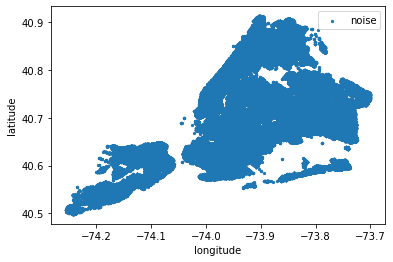

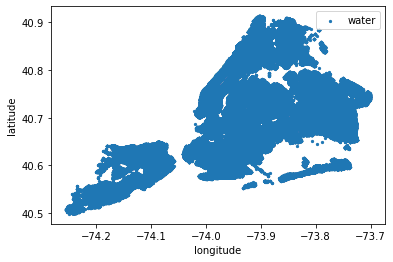

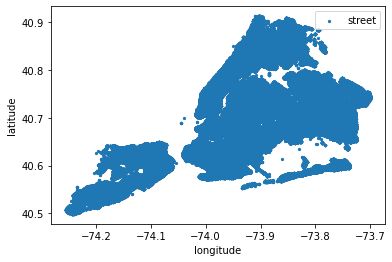

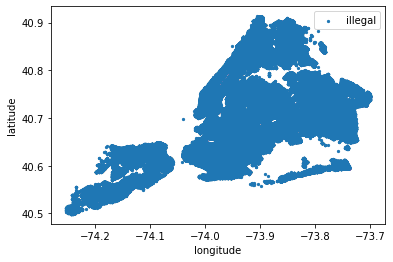

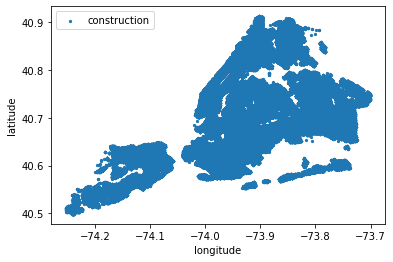

In [35]:
cat_counts = df.complaint_cat.value_counts()

for category, count in cat_counts[:5].iteritems():
    df_plot = df[df.complaint_cat == category]
    df_plot.plot(kind='scatter', x='longitude', y='latitude', subplots=True, label=category, marker=".")

### 2. Create feature: time to resolution (`resolution_time_min`)

In subsequent analysis, we use time to resolution (in minutes) as a feature, thus we create a new column in our dataframe to avoid recomputing

In [36]:
df['time_to_resolution_min'] = (df.closed_date - df.created_date) / pd.Timedelta(minutes=1)

Check legitimacy of requests with `time_to_resolution_min` = 0 (requests closed immediately / no action needed)

In [37]:
df['time_to_resolution_min'].describe()

count    2.135191e+07
mean     2.361290e+04
std      1.089393e+05
min      0.000000e+00
25%      2.160500e+02
50%      3.037000e+03
75%      1.181795e+04
max      5.685137e+06
Name: time_to_resolution_min, dtype: float64

In [38]:
df[df['time_to_resolution_min'] == 0].sample(10)[['created_date', 'closed_date', 'complaint_cat','resolution_description']]

,created_date,closed_date,complaint_cat,resolution_description
22867118,2018-12-16 06:31:00,2018-12-16 06:31:00,water,The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.
17568255,2016-09-07 01:41:00,2016-09-07 01:41:00,sewer,"The Department of Environmental Protection has determined that this issue was previously reported by another customer The original complaint is being addressed. If the condition persists, please call 311 (or 212-639-9675 if calling from a non-New York City area code) to submit a new complaint."
16686666,2016-04-14 10:47:00,2016-04-14 10:47:00,street,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.
11501606,2013-04-02 12:00:00,2013-04-02 12:00:00,rodent,For updated status of your complaint go online at nyc.gov/311 and use the Check Status field or call 311.
350719,2010-07-29 01:24:45,2010-07-29 01:24:45,best/site,"The Department of Buildings determined that the conditions described in this complaint were addressed under another service request number. Click on ""Learn More"" in the ""Did You Know"" section below for more information."
2475094,2013-02-12 02:31:00,2013-02-12 02:31:00,street,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.
8387206,2020-10-21 11:17:25,2020-10-21 11:17:25,maintenance,The Department of Parks and Recreation has completed the requested work order and corrected the problem.
14113136,2015-02-02 12:00:00,2015-02-02 12:00:00,water,The Department of Housing Preservation and Development conducted or attempted to conduct an inspection. More information about inspection results can be found through HPD's website at www.nyc.gov/hpd by using HPDONLINE (enter your address on the home page) and entering your SR number under the complaint status option.
18536950,2017-02-15 12:00:00,2017-02-15 12:00:00,rodent,The Department of Health and Mental Hygiene will review your complaint to determine appropriate action. Complaints of this type usually result in an inspection. Please call 311 in 30 days from the date of your complaint for status
2876632,2013-08-28 11:49:00,2013-08-28 11:49:00,street,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.


### 3. Save data

In [39]:
df.isnull().sum(axis=0)

unique_key                     0
created_date                   0
closed_date                    0
agency                         0
complaint_type                 0
incident_zip                   0
status                         0
resolution_description    408878
latitude                  681234
longitude                 681234
clean_zip                      0
complaint_cat                  0
time_to_resolution_min         0
dtype: int64

In [40]:
print(f'In summary, {(len_df_raw - len(df)) / len_df_raw:.2%} of rows have been dropped from the original dataset')

In summary, 14.98% of rows have been dropped from the original dataset


In [41]:
# drop columns that are not used in subsequent analysis
df.drop(columns=['created_date', 'closed_date', 'status', 'complaint_type', 'incident_zip',
                 'resolution_description', 'latitude', 'longitude'], inplace=True)

In [42]:
# check memory usage
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21351908 entries, 0 to 25115320
Data columns (total 5 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   unique_key              int64  
 1   agency                  string 
 2   clean_zip               string 
 3   complaint_cat           string 
 4   time_to_resolution_min  float64
dtypes: float64(1), int64(1), string(3)
memory usage: 4.2 GB


In [43]:
# check if final dataset looks okay
df.head()

,unique_key,agency,clean_zip,complaint_cat,time_to_resolution_min
0,16181298,HPD,11226,heating,1440.000000
1,16180916,HPD,11218,nonconst,11520.000000
2,16181945,HPD,11225,construction,7200.000000
3,16181032,DOT,10305,street,7535.633333
4,16182497,HPD,11219,plumbing,11520.000000


In [44]:
df.to_csv('data/nyc311_clean.csv', index=False)